# Off-policy MC control for estimating $\pi \approx \pi_*$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
track = \
"""
****     F
***      F
***      F
***   ****
**    ****
**    ****
*     ****
*SSSSS****
"""

In [3]:
arr = []
for line in track.split('\n'):
    if line == '': continue
    temp = []
    for c in line:
        if c == ' ': temp.append(0)
        if c == '*': temp.append(-1)
        if c == 'S': temp.append(1)
        if c == 'F': temp.append(2)
    arr.append(temp)

track = np.array(arr, dtype='int32')

In [88]:
class Racecar:
    MAX_VELOCITY = 5
    MAX_EPISODE_LENGTH = 100
    def __init__(self, track):
        self.track = track

        self._s = []
        for i in range(track.shape[0]):
            for j in range(track.shape[1]):
                if track[i][j] == 1:
                    self._s.append((i, j))

        self.reset()
        self.action_set = [(i, j) for i in [0, 1, -1] for j in [0, 1, -1]]

    
    def step(self, action):
        max_vert, max_horiz = self.track.shape
        Vx, Vy = self.state[2] + action[0], self.state[3] + action[1]
        if Vx > self.MAX_VELOCITY: Vx = MAX_VELOCITY
        if Vy > self.MAX_VELOCITY: Vy = MAX_VELOCITY
        if Vx < 0: Vx = 0
        if Vy < 0: Vy = 0
        if Vx == 0 and Vy == 0: 
            Vx, Vy = 1, 1
            
        self.state[2] = Vx
        self.state[3] = Vy

        self.state[0] -= Vy
        self.state[1] += Vx

        if self.state[0] < 0 or self.state[1] >= max_horiz or self.track[self.state[0], self.state[1]] == -1:
            self.reset()
        elif self.track[self.state[0], self.state[1]] == 2:
            return 1, self.state

        return -1, self.state


    def generate_episodes(self, policy):
        episode = []
        self.reset()
        action = policy[self.state[0], self.state[1], self.state[2], self.state[3]]
        action = self.action_set[action]
        episode.append(['NO REWARD', self.state.copy(), action]) # first time step

        for i in range(self.MAX_EPISODE_LENGTH - 1):
            reward, new_state = self.step(action)
            action = policy[self.state[0], self.state[1], self.state[2], self.state[3]]
            action = self.action_set[action]
            if reward == 1:
                episode.append([reward, new_state.copy(), 'NO ACTION']) # terminal state
                return episode
            episode.append([reward, new_state.copy(), action])
        return episode
            
        
    def display(self):
        pos_h, pos_v = self.state[0], self.state[1]
        cp = self.track.copy()
        cp[pos_h, pos_v] = 4
        fig = plt.figure()
        ax = plt.subplot(111)
        ax.imshow(cp, cmap='inferno')
        ax.set_title('Track')
        
    def reset(self):
        self.state = np.zeros((4,), dtype='int32') # vert, horiz, Vx, Vy
        istart = np.random.choice(len(self._s))
        self.state[0], self.state[1] = self._s[istart]

In [89]:
r = Racecar(track)

In [90]:
while True:
    policy = np.random.randint(0, len(r.action_set), track.shape[0] * track.shape[1] * 36).reshape((track.shape[0], track.shape[1], 6, 6))
    episodes = r.generate_episodes(policy)
    if len(episodes) < 100: break

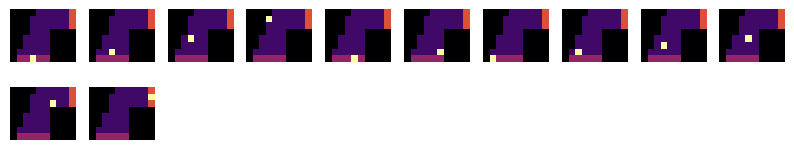

In [91]:
fig = plt.figure(figsize=(10, 10))
cnt = 1
for ep in episodes:
    _, s, a = ep
    pos_vert, pos_horiz = s[0], s[1]
    t = r.track.copy()
    t[pos_vert, pos_horiz] = 4
    ax = plt.subplot(10, 10, cnt)
    ax.imshow(t, cmap='inferno')
    ax.axis('off')
    cnt += 1

In [92]:
def off_policy_mc(track, episodes=100000):
    env = Racecar(track)
    num_actions = len(env.action_set)
    max_vert, max_horiz = track.shape
    Q = np.zeros((max_vert, max_horiz, env.MAX_VELOCITY + 1, env.MAX_VELOCITY + 1, num_actions))
    C = np.zeros((max_vert, max_horiz, env.MAX_VELOCITY + 1, env.MAX_VELOCITY + 1, num_actions))
    policy = np.zeros((max_vert, max_horiz, env.MAX_VELOCITY + 1, env.MAX_VELOCITY + 1))

    for episode in range(episodes):
        ep = env.generate_episodes()

In [93]:
off_policy_mc(track)

9
